In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
import time
df = pd.read_csv('/Users/eduardorodriguez/Desktop/TFM/DATA/banksim/banksim.csv')

le = preprocessing.LabelEncoder()
le.fit(list(set(df['category'])))
df['category'] = le.transform(df['category'])

le.fit(list(set(df['age'])))
df['age'] = le.transform(df['age'])

le.fit(list(set(df['gender'])))
df['gender'] = le.transform(df['gender'])

df_data = df
#X = df.loc[(df.category == 'es_sportsandtoys') | (df.category == 'es_fashion') | (df.category == 'es_travel') | (df.category == 'es_home') |(df.category == 'es_health') | (df.category == 'es_leisure') | df.category == 'es_tech') | (df.category == 'es_otherservices') | (df.category == 'es_barsandrestaurants') |(df.category == 'es_hyper') | (df.category == 'es_wellnessandbeauty')]
y = df_data['fraud']

df = df.drop(['customer', 'merchant', 'zipMerchant', 'zipcodeOri'], axis = 1)
X = df_data.drop(['customer', 'merchant', 'zipMerchant', 'zipcodeOri', 'fraud'], axis = 1)
X.head()

,step,age,gender,category,amount
0,0,4,2,12,4.55
1,0,2,2,12,39.68
2,0,4,1,12,26.89
3,0,3,2,12,17.25
4,0,5,2,12,35.72


## Split data by 50-50

In [5]:
TEST_RATIO = 0.2
df.sort_values('step', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, :-1].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, :-1].values
test_y = df.iloc[TRA_INDEX:, -1].values

## Pre-processing - z scores

In [5]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

## import RBM

In [6]:
from rbm import RBM

## Initialize model object with momentum

In [7]:
model = RBM(train_x.shape[1], 10, visible_unit_type='gauss', main_dir='model', model_name='rbm_model.ckpt',
                 gibbs_sampling_steps=4, learning_rate=0.00001, momentum = 0.95, batch_size=10000, num_epochs=200, verbose=1)


## Train it and plot training reconstruction loss v.s. iteractions

Validation cost at step 0: 1.2291074
Validation cost at step 1: 1.2762034
Validation cost at step 2: 1.2619282
Validation cost at step 3: 1.2924548
Validation cost at step 4: 1.2908858
Validation cost at step 5: 1.2699268
Validation cost at step 6: 1.2720201
Validation cost at step 7: 1.2603142
Validation cost at step 8: 1.271427
Validation cost at step 9: 1.2688937
Validation cost at step 10: 1.2956104
Validation cost at step 11: 1.2864671
Validation cost at step 12: 1.221134
Validation cost at step 13: 1.2765659
Validation cost at step 14: 1.2103418
Validation cost at step 15: 1.3002584
Validation cost at step 16: 1.2766975
Validation cost at step 17: 1.2770101
Validation cost at step 18: 1.2371801
Validation cost at step 19: 1.2775892
Validation cost at step 20: 1.2679847
Validation cost at step 21: 1.2453945
Validation cost at step 22: 1.212926
Validation cost at step 23: 1.2671397
Validation cost at step 24: 1.2939246
Validation cost at step 25: 1.2938465
Validation cost at step 2

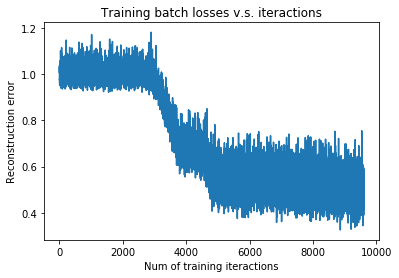

In [8]:
start = time.clock() 
model.fit(train_x, validation_set=test_x)
elapsed2 = time.clock()
elapsed2 = elapsed2 - start

## Make predictions on val - Free Energy

In [9]:
elapsed2

394.91342000000003

In [10]:
start = time.clock()
test_cost = model.getFreeEnergy(test_x).reshape(-1)
elapsed = time.clock()
elapsed = elapsed - start

INFO:tensorflow:Restoring parameters from model/rbm_model.ckpt


In [11]:
elapsed

0.08025400000002492

## AUC-ROC curve on val

In [12]:
auc(test_y, test_cost)

0.8009393341103621

In [13]:
#Creating class labels based on decision function
test_cost=test_cost.copy()
test_cost[test_cost>=np.percentile(test_cost,95)]=1
test_cost[test_cost<np.percentile(test_cost,95)]=0

In [14]:
f1_score(test_y, test_cost)

0.1934412619344126

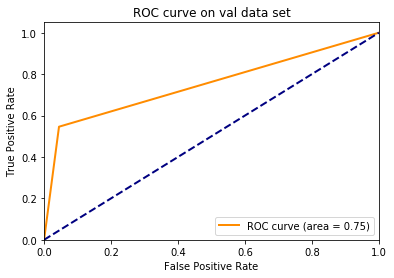

In [15]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_y, test_cost)

fpr_micro, tpr_micro, _ = roc_curve(test_y, test_cost)
roc_auc = auc(fpr_micro, tpr_micro)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on val data set')
plt.legend(loc="lower right")
plt.show()

## Distribution for FE on val set - fraud and non-fraud

/Users/eduardorodriguez/anaconda2/envs/TFM/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


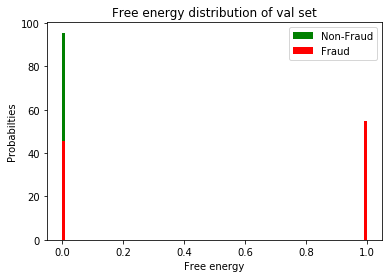

In [16]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.title('Free energy distribution of val set')
plt.xlabel('Free energy')
plt.ylabel('Probabilties')
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', normed=1.0, label='Non-Fraud')
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', normed=1.0, label = 'Fraud')

plt.legend(loc="upper right")
plt.show()

/Users/eduardorodriguez/anaconda2/envs/TFM/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


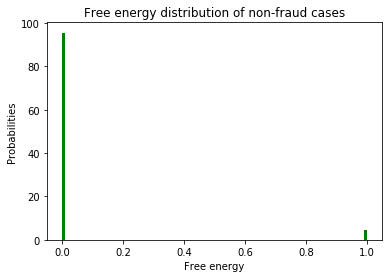

In [17]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', normed=1)

plt.title('Free energy distribution of non-fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

In [18]:
import plotly.plotly as py
import plotly.graph_objs as go
data = list(map(int, list(test_cost[(test_y == 0) & (test_cost < 500)])))
py.iplot(data, filename='basic histogram', validate=False)

TypeError: argument of type 'int' is not iterable

In [ ]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', normed=1)
plt.title('Free energy distribution of fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

## Finding a threshold for real time fraud detector

### Precision Recall Curve in general

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(lines):
    

    for precision, recall, label in lines:
        plt.plot(recall, precision, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc="upper right")
    plt.show()
    
lines = []
precision, recall, threshold = precision_recall_curve(test_y, test_cost)

lines.append( (precision, recall, 'Precision Recall Curve') )
plot_precision_recall(lines)

### Finding a threshold of Free Energy on range(0, 200) that best balances Precision and Recall

In [ ]:
#precisions = []
#recalls = []
#all_pos = sum(test_y)
#for threshold in range(1, 200):
#    all_predicted = sum(test_cost > threshold)
#    TP = sum((test_cost > threshold) & (test_y == 1))
    
#    precisions.append(TP  / all_predicted)
#    recalls.append(TP / all_pos)

#plt.plot( recalls, label = 'recall')
#plt.axvline(100, color = 'red')

#plt.title("Recall curve")
#plt.xlabel("FE")
#plt.ylabel("Recall")
#plt.legend()
#plt.show()

In [ ]:
#plt.plot( precisions, label = 'precision')
#plt.axvline(100, color = 'red')

#plt.title("Precision curve")
#plt.xlabel("FE")
#plt.ylabel("Precision")
#plt.legend()
#plt.show()

## Take a look at the top 500 transactions for example ....

In [ ]:
#value_500 = sorted(test_cost)[-500]
#population_mean = np.mean(test_y)
#model_mean_500 = np.mean(test_y[test_cost > value_500])
#print("Perc of fraud in val data is: %0.2f%%; perc of fraud in top 500 by model is: %0.2f%%" % (population_mean*100, model_mean_500*100))